In [1]:
%pylab inline
import radvel
import radvel.likelihood

import corner
import copy

from scipy import optimize
rc('savefig',dpi=120)

# Convenient function for plotting fits
def plot_results(like):
    fig = gcf()
    errorbar(
        like.x, like.model(t)+like.residuals(), 
        yerr=like.yerr, fmt='o'
        )
    plot(ti, like.model(ti))
    xlabel('Time')
    ylabel('RV')
    draw()

Populating the interactive namespace from numpy and matplotlib


Intialize Keplerian model parameters
====================================

In [2]:
params = radvel.Parameters(1,basis='per tc secosw sesinw k')
params['k1'] = radvel.Parameter(value=1)
params['per1'] = radvel.Parameter(value=1)
params['secosw1'] = radvel.Parameter(value=0.1)
params['sesinw1'] = radvel.Parameter(value=+0.2)
params['tc1'] = radvel.Parameter(value=0.)
rv_mod = radvel.RVModel(params)

Generate Synthetic Data
=======================

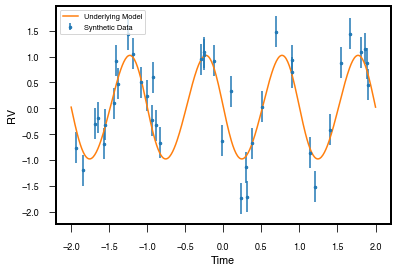

In [3]:
t = np.random.random_sample(40)
t = t * 4 - 2
t = np.sort(t)
ti = np.linspace(-2,2,400)
errvel = 0.3
jitter = 0.3
syn_rv = rv_mod(t) + randn(t.size)*np.sqrt(errvel**2 + jitter**2)
errorbar(t,syn_rv,yerr=errvel,fmt='.',label='Synthetic Data')
plot(ti,rv_mod(ti),label='Underlying Model')
xlabel('Time')
ylabel('RV')
legend()

Generate a likelihood
=====================

In [45]:
like_syn = radvel.likelihood.RVLikelihood(rv_mod,t,syn_rv,zeros(t.size)+errvel)
like_syn.params['gamma'] = radvel.Parameter(value=0)
like_syn.params['jit'] = radvel.Parameter(value=errvel)

truths = copy.deepcopy(like_syn.params) # Store away model parameters for later reference
like_syn.params.update(dict(k1=radvel.Parameter(value=3),
                            secosw1=radvel.Parameter(value=0.1),
                            sesinw1=radvel.Parameter(value=0.1),
                            tc1=radvel.Parameter(value=0.1))) # perturb the starting guess

like_syn.params['jit'].vary = False # Don't vary jitter

Perform a maximum likelihood fit
===============================

 final_simplex: (array([[ 0.99384561,  0.01864948, -0.21488331, -0.1269259 ,  1.14585167,
         0.09837909],
       [ 0.99383759,  0.01859887, -0.2144245 , -0.1271479 ,  1.14570017,
         0.0982629 ],
       [ 0.99384792,  0.01861784, -0.21460807, -0.12699223,  1.14565481,
         0.09837183],
       [ 0.99384095,  0.01864701, -0.21481664, -0.12683671,  1.14567207,
         0.09837955],
       [ 0.99385478,  0.01861124, -0.21459884, -0.12681333,  1.14585779,
         0.09826763],
       [ 0.99384488,  0.01862333, -0.21454318, -0.12700519,  1.14580259,
         0.09839979],
       [ 0.99386236,  0.01864303, -0.21465761, -0.12731322,  1.14582781,
         0.09825469]]), array([20.13544419, 20.13544422, 20.13544439, 20.13544478, 20.13544546,
       20.13544609, 20.13544692]))
           fun: 20.13544419368913
       message: 'Maximum number of function evaluations has been exceeded.'
          nfev: 1201
           nit: 772
        status: 1
       success: False
             x: ar

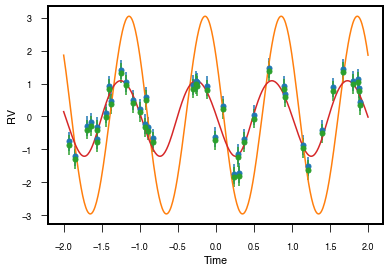

In [46]:
plot_results(like_syn) # Plot initial model
res  = optimize.minimize(like_syn.neglogprob_array, like_syn.get_vary_params(), method='Nelder-Mead' )
#res  = optimize.minimize(like_syn.neglogprob_array, like_syn.get_vary_params(), method='L-BFGS-B' )
print(res)
print(like_syn)
plot_results(like_syn) # plot best fit model

Instantiate a posterior object
===============================

In [54]:
post = radvel.posterior.Posterior(like_syn)
post.params['per1'] = radvel.Parameter(value=1)
post.params['k1'] = radvel.Parameter(value=1)
post.params['jit'].vary = False
post.priors += [radvel.prior.EccentricityPrior( 1 )]
post.priors += [radvel.prior.Gaussian( 'jit', errvel, 0.1)]
post.priors += [radvel.prior.Gaussian( 'per1', 1, 0.1)]
post.priors += [radvel.prior.Gaussian( 'tc1', 0, 0.1)]

post.priors += [radvel.prior.SecondaryEclipsePrior(1, 0.5, 0.01)]

print(post)
# like_syn.name_vary_params()
# like_syn.vector.names
like_syn.params

parameter                     value      vary
per1                              1       True
tc1                             0.1       True
secosw1                         0.1       True
sesinw1                         0.1       True
k1                                3       True
gamma                             0       True
jit                             0.3      False
tp1                      -0.0205459           
e1                             0.02           
w1                         0.785398           

Priors
------
e1 constrained to be < 0.99
Gaussian prior on jit, mu=0.3, sigma=0.1
Gaussian prior on per1, mu=1, sigma=0.1
Gaussian prior on tc1, mu=0, sigma=0.1
secondary eclipse constraint: 0.5 +/- 0.01



Parameters([('per1',
             Parameter object: value = 1.0, vary = True, mcmc scale = None),
            ('tc1',
             Parameter object: value = 0.1, vary = True, mcmc scale = None),
            ('secosw1',
             Parameter object: value = 0.1, vary = True, mcmc scale = None),
            ('sesinw1',
             Parameter object: value = 0.1, vary = True, mcmc scale = None),
            ('k1',
             Parameter object: value = 3.0, vary = True, mcmc scale = None),
            ('gamma',
             Parameter object: value = 0.0, vary = True, mcmc scale = None),
            ('jit',
             Parameter object: value = 0.3, vary = False, mcmc scale = None)])

Perform maximum likelihood fit on posterior
=========================================

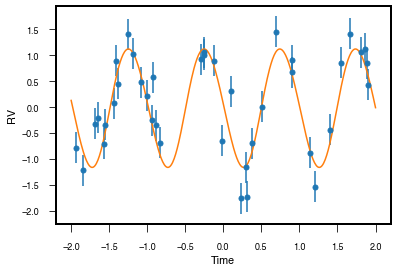

In [55]:
res  = optimize.minimize(post.neglogprob_array, post.get_vary_params(), method='Nelder-Mead' )
plot_results(post.likelihood)

Use mcmc to sample the posterior distribution
========================

1. use `emcee` package to run MCMC
1. corner plot visualizes parameters and correlations
1. Blue lines show the synthetic model parameters

In [56]:
df = radvel.mcmc(post,nwalkers=20,nrun=1000,savename='rawchain.h5')

IndexError: list index out of range

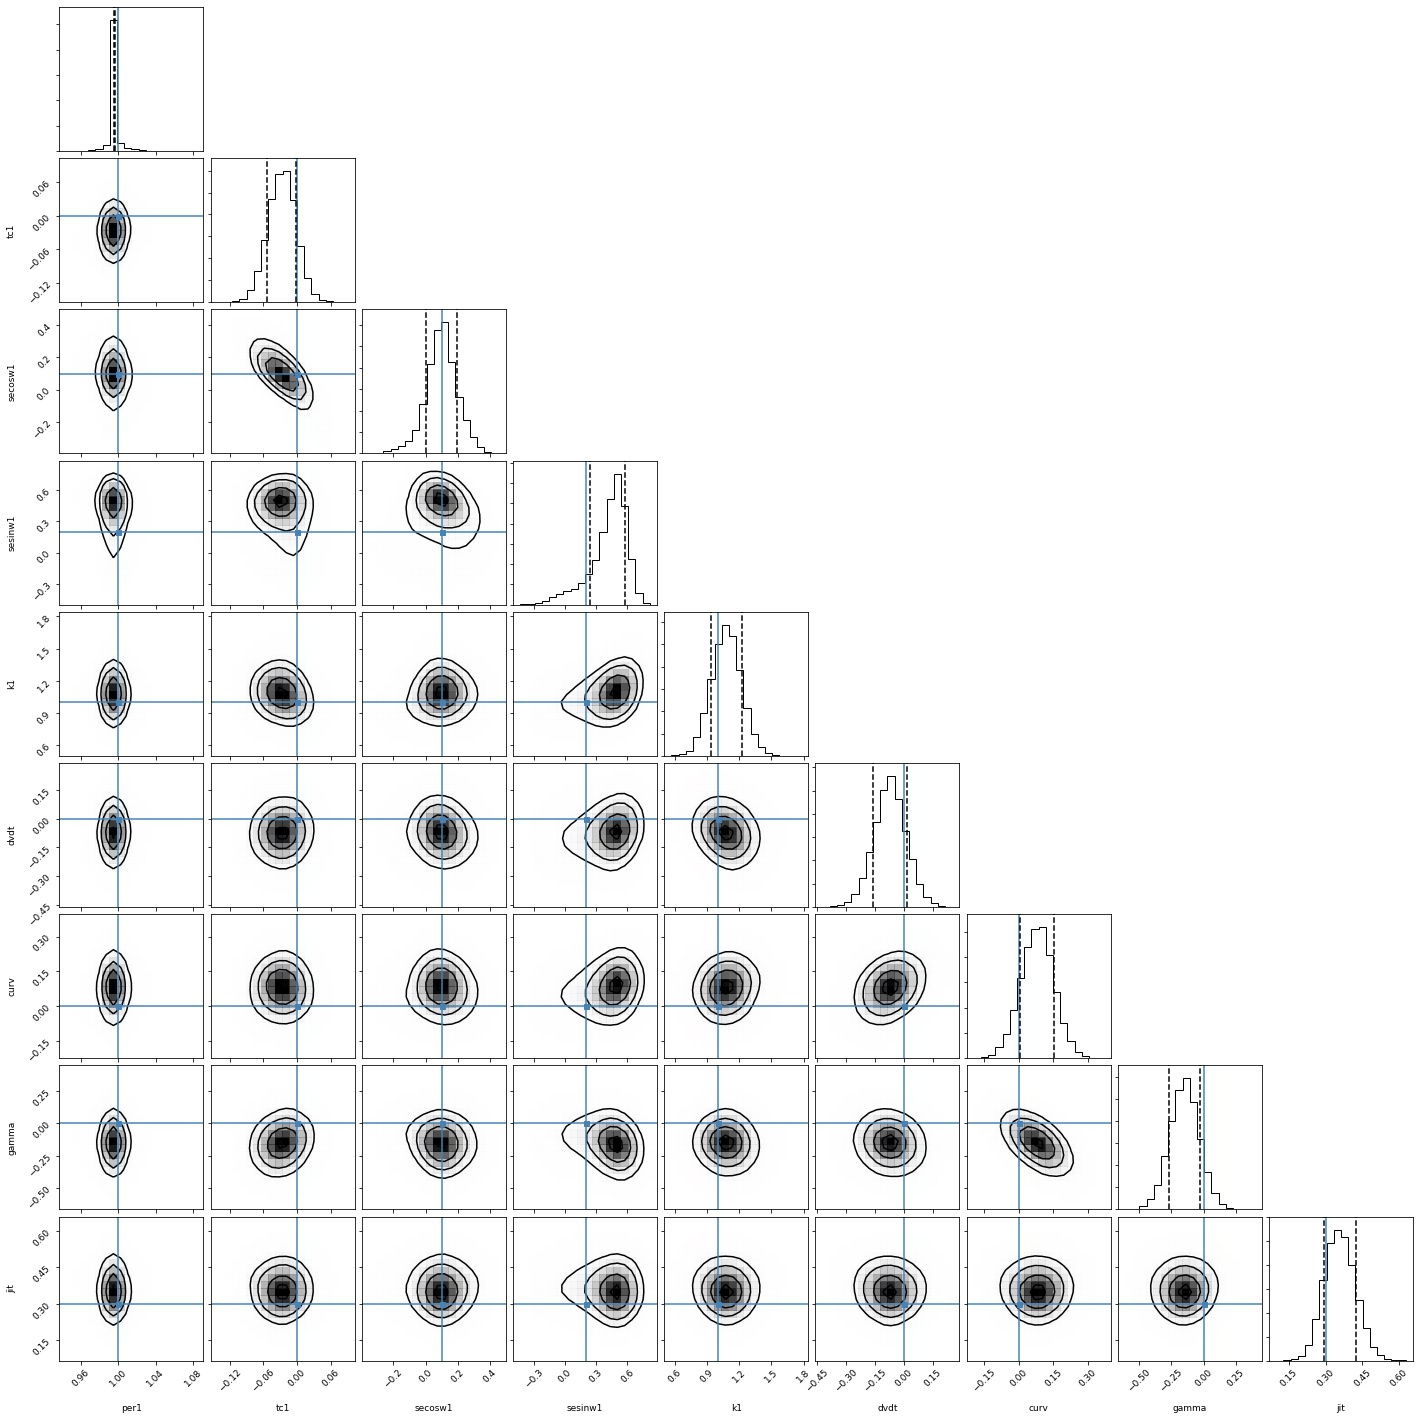

In [9]:
labels = [k for k in post.params.keys() if post.params[k].vary]



fig = corner.corner(
    df[labels],
    labels=labels,
    truths=[truths[k].value for k in labels ],
    quantiles=[0.15,0.85],
    plot_datapoints=False,
    smooth=True,
    bins=20
    )